### Datos del sujeto P001 en la sesion TEST01

In [13]:
import pandas as pd

# Cargar los datos en un DataFrame
df_P001_EDA_PPT= pd.read_csv('TEST01/E4/P001/EDA_PPT.csv')

# Mostrar las primeras filas del DataFrame para verificar la carga
df_P001_EDA_PPT.head()

,Time (s),EDA
0,0.139,0.17678
1,0.389,0.17934
2,0.639,0.17550
3,0.889,0.17550
4,1.139,0.17678


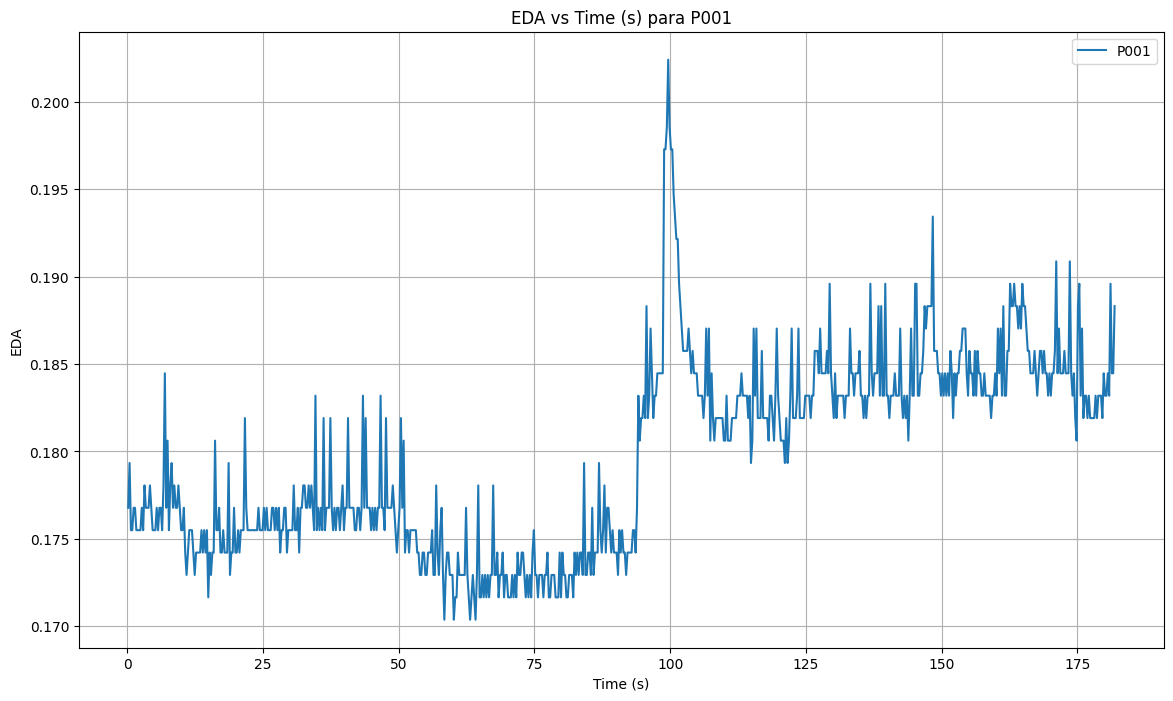

In [15]:
import matplotlib.pyplot as plt

# Graficar EDA vs Time (s) para df_P001_EDA_PPT
plt.figure(figsize=(14, 8))
plt.plot(df_P001_EDA_PPT['Time (s)'], df_P001_EDA_PPT['EDA'], label='P001')

plt.xlabel('Time (s)')
plt.ylabel('EDA')
plt.title('EDA vs Time (s) para P001')
plt.legend()
plt.grid(True)
plt.show()

#### Proceso de desconvolución de las señal

Las señales EDA se componen de dos señales que se combinan (convolucionan), estas son:

Nivel Electrodérmico (ECL o SCL ): Es la señal de base, que varía lentamente a lo largo del tiempo.
Representa la actividad tónica de las glándulas sudoríparas, esta se puede despreciar ya que informa los cambios en la confuctancia electrodérmica en relación con la temperatura y humedad del medio ambiente o el movimiento del cuerpo.

Respuesta Electrodérmica (EDR o SCR): Es una señal que varía rápidamente y está estrechamente relacionada con el sistema nervioso simpático (SNS) encargado de preparar el cuerpo para afrontar situaciones de estres. 

Por lo tanto es necesario descomponer la señal EDA para poder aislar los datos obtenidos de señal SCR la cual varía directamente con el estres.

#### Uso de la función cvxEDA

La función `cvxEDA` es proporcionada por Luca Citi y Alberto Greco. Puedes encontrar más información en [este enlace](https://github.com/lciti/cvxEDA/tree/master).

##### Instalación de la dependencia

Para utilizar `cvxEDA`, es necesario instalar la dependencia `cvxopt`. 
Ejecutando el siguiente comando:

pip install cvxopt


     pcost       dcost       gap    pres   dres
 0: -1.1763e+01 -1.1181e+01  7e+02  3e+01  6e-01
 1: -1.1192e+01 -4.1705e+01  3e+01  1e+00  2e-02
 2: -1.1191e+01 -1.2347e+01  1e+00  2e-02  5e-04
 3: -1.1603e+01 -1.1765e+01  2e-01  2e-04  5e-06
 4: -1.1747e+01 -1.1763e+01  2e-02  2e-05  4e-07
 5: -1.1760e+01 -1.1762e+01  2e-03  2e-07  4e-09
 6: -1.1762e+01 -1.1762e+01  3e-04  2e-08  3e-10
 7: -1.1762e+01 -1.1762e+01  3e-05  8e-10  2e-11
 8: -1.1762e+01 -1.1762e+01  2e-06  5e-11  1e-12
 9: -1.1762e+01 -1.1762e+01  5e-08  6e-13  1e-14
Optimal solution found.


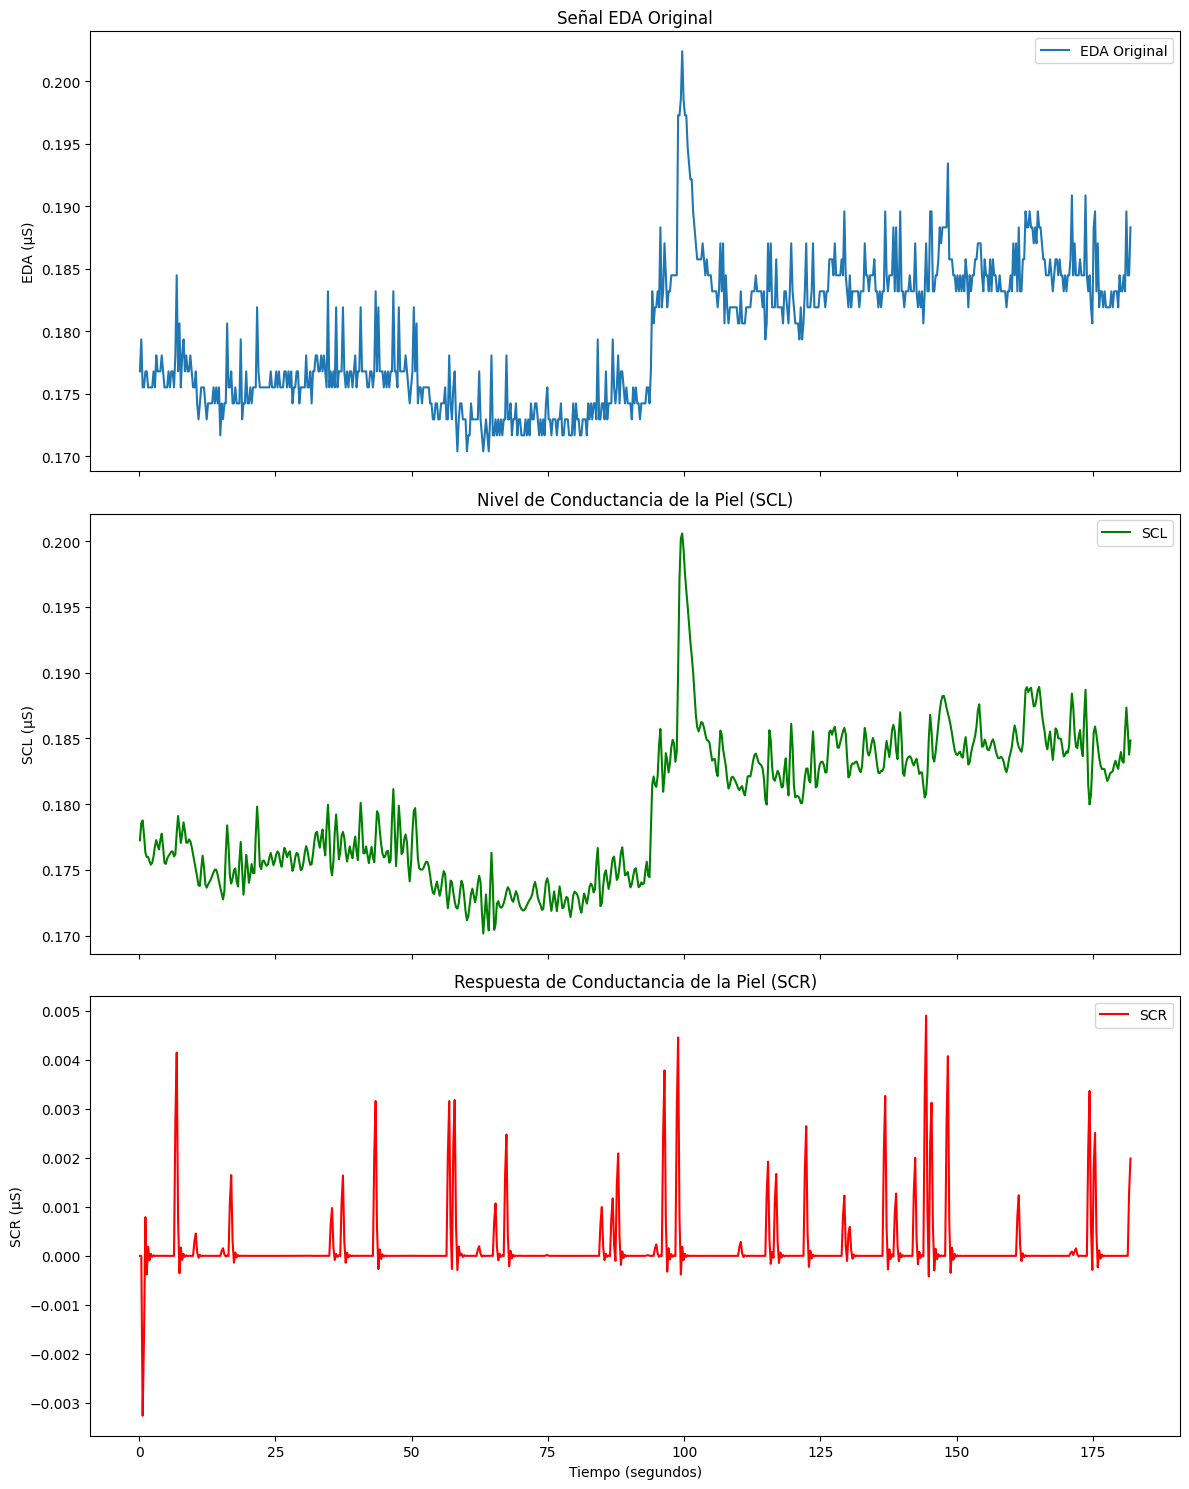

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from cvxEDA import cvxEDA

# Preparar los datos para cvxEDA
y = df_P001_EDA_PPT['EDA'].values
t = df_P001_EDA_PPT['Time (s)'].values
dt = np.mean(np.diff(t))  # Intervalo de muestreo promedio

# Realizar la desconvolución
[r, p, t, l, d, e, obj] = cvxEDA(y, 1./dt)

# Crear un nuevo DataFrame con los resultados
results = pd.DataFrame({
    'time': df_P001_EDA_PPT['Time (s)'],
    'original_EDA': y,
    'SCL': t,  # Componente tónica (Skin Conductance Level)
    'SCR': r,  # Componente fásica (Skin Conductance Response)
})

# Crear la figura con tres subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Graficar EDA original
ax1.plot(results['time'], results['original_EDA'], label='EDA Original')
ax1.set_title('Señal EDA Original')
ax1.set_ylabel('EDA (μS)')
ax1.legend()

# Graficar SCL (componente tónica)
ax2.plot(results['time'], results['SCL'], label='SCL', color='green')
ax2.set_title('Nivel de Conductancia de la Piel (SCL)')
ax2.set_ylabel('SCL (μS)')
ax2.legend()

# Graficar SCR (componente fásica)
ax3.plot(results['time'], results['SCR'], label='SCR', color='red')
ax3.set_title('Respuesta de Conductancia de la Piel (SCR)')
ax3.set_xlabel('Tiempo (segundos)')
ax3.set_ylabel('SCR (μS)')
ax3.legend()

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

# Opcional: Guardar los resultados en un nuevo archivo CSV
results.to_csv('deconvolved_EDA.csv', index=False)

#### Definición del estado como "estresado" o "no estresado"

Se consideran los reportes autodescriptivos de los participantes, como esta es la señal en el momento en que se da el discurso, se considerará el reporte TEST01_afterPPT que fue respondido luego de realizar el discurso.

Se considera el campo State Anxiety Enthusiasm Score para determinar si la persona estuvo estresada o no durante el discurso.

Por lo que es necesario definir un umbral para realizar una determinación binaria que indique si la persona estuvo estresada o no.


##### Definición del umbral de State Anxiety Enthusiasm
Gráfico de distribución de los datos.


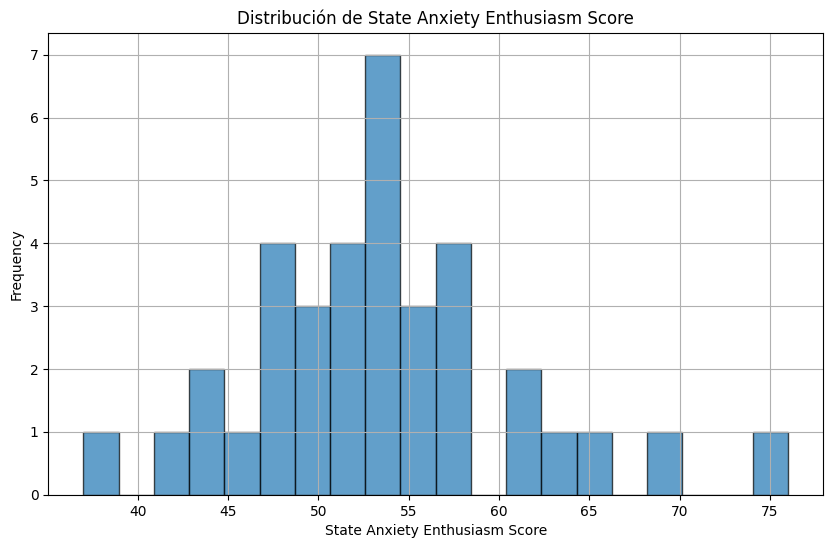

In [24]:
import pandas as pd

import matplotlib.pyplot as plt

# Cargar los datos del archivo CSV
df_self_reports = pd.read_csv('TEST01/Self_Reports/TEST01_afterPPT.csv')

# Graficar la distribución de "State Anxiety Enthusiasm Score"
plt.figure(figsize=(10, 6))
plt.hist(df_self_reports['State Anxiety Enthusiasm Score'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('State Anxiety Enthusiasm Score')
plt.ylabel('Frequency')
plt.title('Distribución de State Anxiety Enthusiasm Score')
plt.grid(True)
plt.show()

Se calcula el rango intercuartílico (IQR), que es la diferencia entre el percentil 75 y el percentil 25. 
Esto mide la dispersión de los datos.
Si el IQR es mayor que la diferencia entre el percentil 75 y el puntaje mínimo, se selecciona el percentil 75 como umbral, lo que indica que los valores por encima de este percentil se consideran de personas no estresadas.
De lo contrario, se selecciona el percentil 25 como umbral, y los valores por debajo de este se consideran de personas estresadas.


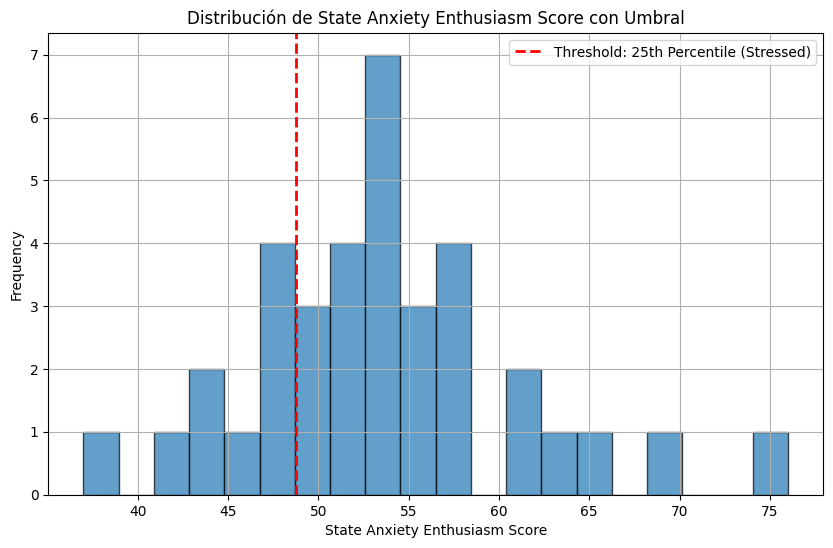

In [25]:

# Calcular los percentiles
percentile_75 = df_self_reports['State Anxiety Enthusiasm Score'].quantile(0.75)
percentile_25 = df_self_reports['State Anxiety Enthusiasm Score'].quantile(0.25)

# Determinar el mejor umbral basado en la dispersión de los datos
iqr = percentile_75 - percentile_25
if iqr > (percentile_75 - df_self_reports['State Anxiety Enthusiasm Score'].min()):
    best_threshold = percentile_75
    threshold_label = '75th Percentile (Non-Stressed)'
else:
    best_threshold = percentile_25
    threshold_label = '25th Percentile (Stressed)'

# Graficar la distribución con el umbral
plt.figure(figsize=(10, 6))
plt.hist(df_self_reports['State Anxiety Enthusiasm Score'], bins=20, edgecolor='k', alpha=0.7)
plt.axvline(best_threshold, color='r', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold_label}')
plt.xlabel('State Anxiety Enthusiasm Score')
plt.ylabel('Frequency')
plt.title('Distribución de State Anxiety Enthusiasm Score con Umbral')
plt.legend()
plt.grid(True)
plt.show()

Se agrega el nuevo campo stressed dependiendo si el el valor de su encuesta es superior a best_threshold se considerará como estresado

In [29]:
print(best_threshold)
# Crear una nueva columna 'stressed' basada en el umbral
df_self_reports['stressed'] = df_self_reports['State Anxiety Enthusiasm Score'].apply(lambda x: 1 if x >= best_threshold else 0)

# Crear un nuevo DataFrame con las columnas requeridas
df_stress_status = df_self_reports[['PID', 'State Anxiety Enthusiasm Score', 'stressed']]

df_stress_status.head()

48.75


,PID,State Anxiety Enthusiasm Score,stressed
0,P001,54,1
1,P004,53,1
2,P005,48,0
3,P008,58,1
4,P013,54,1


#### Segmentar la señal en ventanas de 30 segundos

In [23]:
# Definir el tamaño de la ventana en segundos
window_size = 30

# Crear una columna para identificar cada ventana
results['window'] = (results['time'] // window_size).astype(int)

# Agrupar por ventana y calcular estadísticas
segmented_results = results.groupby('window').agg({
    'time': ['min', 'max'],
    'original_EDA': ['mean', 'std'],
    'SCL': ['mean', 'std'],
    'SCR': ['mean', 'std']
}).reset_index()

# Renombrar las columnas para mayor claridad
segmented_results.columns = [
    'window', 'start_time', 'end_time', 
    'mean_original_EDA', 'std_original_EDA', 
    'mean_SCL', 'std_SCL', 
    'mean_SCR', 'std_SCR'
]

# Mostrar los resultados segmentados
segmented_results.head()

,window,start_time,end_time,mean_original_EDA,std_original_EDA,mean_SCL,std_SCL,mean_SCR,std_SCR
0,0,0.139,29.889,0.175873,0.001760,0.175806,0.001357,0.000059,0.000604
1,1,30.139,59.889,0.176247,0.002311,0.176063,0.001937,0.000182,0.000625
2,2,60.139,89.889,0.173271,0.001712,0.173173,0.001282,0.000119,0.000401
3,3,90.139,119.889,0.183380,0.005537,0.183194,0.005330,0.000183,0.000687
4,4,120.139,149.889,0.184128,0.002387,0.183782,0.001817,0.000344,0.000909


### Carga de los datos de todos los participantes en la sesion TEST01

In [11]:
pid_participants = pd.read_csv('TEST01/participant_id.csv')

# Mostrar las primeras filas del nuevo DataFrame para verificar la carga
pid_participants["PID"].head

# Reemplazar 'P001' por cada valor de PID en pid_participants y cargar los datos en un DataFrame
df_list = []

for pid in pid_participants["PID"]:
    file_path = f'TEST01/E4/{pid}/EDA_PPT.csv'
    df_pid = pd.read_csv(file_path)
    df_pid['PID'] = pid  # Añadir una columna para identificar el PID
    df_list.append(df_pid)

df_test01_EDA_PPT = pd.concat(df_list, ignore_index=True)
df_test01_EDA_PPT.head()

,Time (s),EDA,PID
0,0.139,0.17678,P001
1,0.389,0.17934,P001
2,0.639,0.17550,P001
3,0.889,0.17550,P001
4,1.139,0.17678,P001


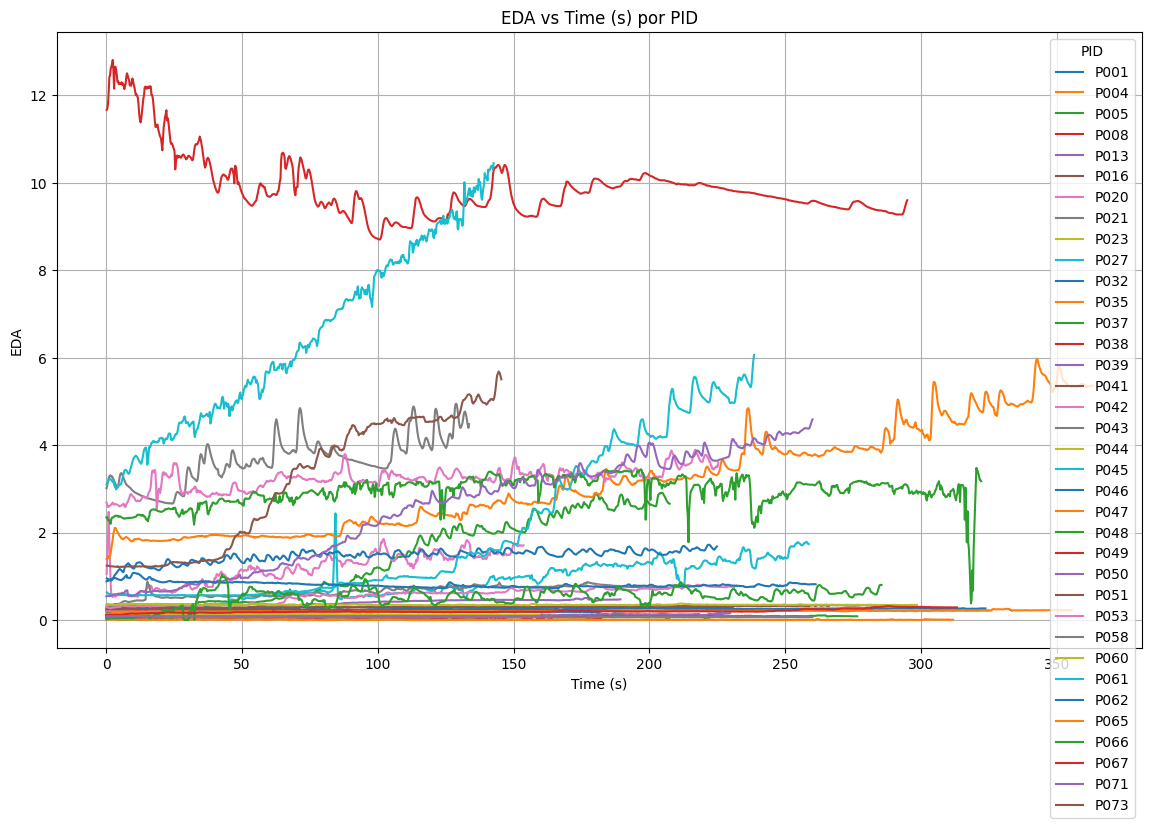

In [14]:
import matplotlib.pyplot as plt

# Graficar EDA vs Time (s) por PID
plt.figure(figsize=(14, 8))

# Obtener los PIDs únicos
unique_pids = df_test01_EDA_PPT['PID'].unique()

# Graficar cada PID con un color diferente
for pid in unique_pids:
    df_pid = df_test01_EDA_PPT[df_test01_EDA_PPT['PID'] == pid]
    plt.plot(df_pid['Time (s)'], df_pid['EDA'], label=pid)

plt.xlabel('Time (s)')
plt.ylabel('EDA')
plt.title('EDA vs Time (s) por PID')
plt.legend(title='PID')
plt.grid(True)
plt.show()